In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms

from mean_std import mean_std

In [2]:
# Determine the model architecture
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),

            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120),

            # ReLU activation
            nn.ReLU(inplace=True),

            # second fully connected layer
            # in_features = output of last linear layer = 120
            nn.Linear(in_features=120, out_features=84),

            # ReLU activation
            nn.ReLU(inplace=True),

            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

In [3]:
# Download files for testing pre-trained models
files = []
for root, dirs, file in os.walk("./images"):
    for name in file:
        files.append(name)

images = []  # for original images
img_labels = []  # for image of different components
img_labels_num = []  # for number of components
centroids = []  # for centers of components
for file_name in files:
    # Read and add border to image
    image = cv2.imread('images/' + file_name, 0)
    image = cv2.copyMakeBorder(image, 14, 14, 14, 14, cv2.BORDER_CONSTANT, None, 0)
    images.append(image)

    # Find connected components
    etval, labels, stats, centroid = \
        cv2.connectedComponentsWithStatsWithAlgorithm(image, 4, cv2.CV_16U, cv2.CCL_WU)
    img_labels.append(labels)
    centroids.append(centroid)

    # If find less then 4 digits - print that
    nComponents = labels.max()
    img_labels_num.append(nComponents)
    if nComponents < 4:
        print("Numbers in " + file_name + " are too close, program will not find all digits")


In [4]:
model_param = []  # for plotting result of testing models
#For all pre-trained models 
for name, (mean, std) in mean_std.items(): 
    # Download model
    model = LeNetBN()
    model.load_state_dict(torch.load('models/' + name + '.pth', map_location=torch.device('cpu')))

    confidence = []  # for confidance from 0.0 to 1.0
    digit_acc = []  # accuracy of digits recognition
    num_acc = []  # accuracy of number(4 digits) recognition
    for im_num in range(len(images)):
        number = []
        miss = []  # put i if digit too close and have one component
        for i in range(1, img_labels_num[im_num] + 1):
            # Crop image (28, 28) with one digit in the center
            centerX, centerY = map(int, centroids[im_num][i])
            img = np.where(img_labels[im_num] == i, images[im_num], 0)
            img = img[centerY - 14:centerY + 14, centerX - 14:centerX + 14]
            if img.shape[1] > 28:
                # Will miss second digit
                img = img[:, :28]
                miss.append(i)
            # Prepare for model input
            img = torch.tensor(img.astype(np.uint8))
            img = img[None]
            img = transforms.ToPILImage()(img)
            img = transforms.Resize((32, 32))(img)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize((mean, ), (std, ))(img)
            img = img[None]
            # Predict
            score = model(img)
            prob = nn.functional.softmax(score[0], dim=0)
            y_pred = prob.argmax()
            number.append([centroids[im_num][i][0], y_pred.cpu().data.numpy().tolist()])
            confidence.append(prob[y_pred].cpu().data.numpy().tolist())

        # Sort by X coordinate
        number.sort()
        number = ''.join([str(i[1]) for i in number])
        #print("Model: " + name + ", predict number " + files[im_num][1:5] + " as "  + number)
        # If have miss digits
        for m in miss:
            number = number[:m] + 'O' + number[m:]
        for n in range(4):
            digit_acc.append(files[im_num][n+1] == number[n])
        # Append True, if predicted number equal real value
        # Real value contains in name of image (can be transform)
        num_acc.append(files[im_num][1:5] == number)
    
    # Append to list model parameters 
    model_param.append([name, sum(num_acc), sum(digit_acc), sum(confidence)/len(confidence)])
    print("Model: {}, Number accuracy: {}, Digit accuracy: {}, with confidence: {}".format(\
    model_param[-1][0], model_param[-1][1]/len(num_acc), model_param[-1][2]/len(digit_acc), model_param[-1][3]))


Model: MNIST_model, Number accuracy: 0.8, Digit accuracy: 0.925, with confidence: 0.9262010805308819
Model: SVHM_model, Number accuracy: 0.9, Digit accuracy: 0.975, with confidence: 0.8872467018663883
Model: MNIST_SVHM_model, Number accuracy: 0.7, Digit accuracy: 0.925, with confidence: 0.8754325903952122
Model: aug_model, Number accuracy: 0.0, Digit accuracy: 0.5, with confidence: 0.8589672163128853
Model: MNIST_aug_model, Number accuracy: 0.7, Digit accuracy: 0.925, with confidence: 0.9351118773221969
Model: SVHM_aug_model, Number accuracy: 0.8, Digit accuracy: 0.95, with confidence: 0.9011108078062534
Model: MNIST_SVHM_aug_model, Number accuracy: 1.0, Digit accuracy: 1.0, with confidence: 0.9689892694354058


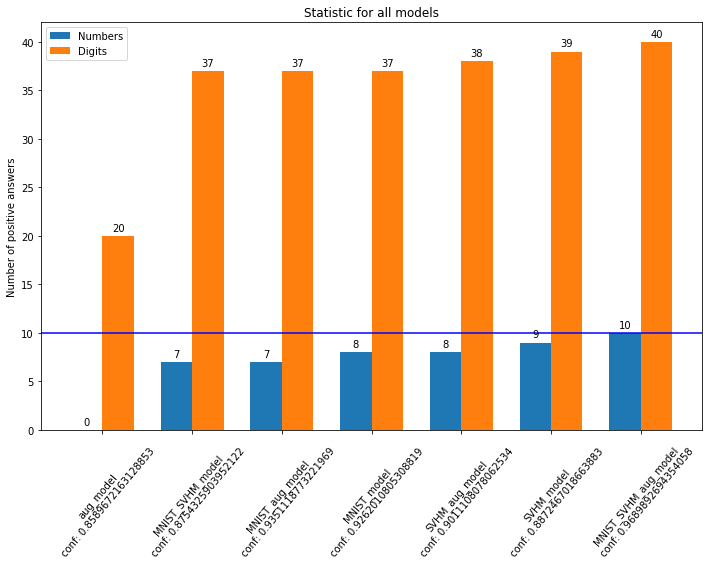

In [5]:
# Conver to NumPy for slicing by dimension and sort by correct digit answers
model_param = np.array(model_param)
model_param = model_param[np.argsort(model_param[:, 1].astype(np.uint8))]

# Plot results
fig, ax = plt.subplots(figsize=(10, 8))
N_acc = ax.bar(np.arange(len(mean_std)) - 0.35 / 2, model_param[:, 1].astype(np.uint8), 0.35, label='Numbers')
D_acc = ax.bar(np.arange(len(mean_std)) + 0.35 / 2, model_param[:, 2].astype(np.uint8), 0.35, label='Digits')

ax.set_ylabel('Number of positive answers')
ax.set_title('Statistic for all models')
ax.set_xticks(np.arange(len(mean_std)))
ax.set_xticklabels(np.core.defchararray.add(np.core.defchararray.add(model_param[:, 0], "\n conf: "), model_param[:, 3]), rotation=50)
ax.legend()
ax.axhline(len(images), color="blue")  # line for max score of numbers clasification
#ax.axhline(len(images)*4, color="orange")


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(N_acc)
autolabel(D_acc)

fig.tight_layout()
plt.show()